<a href="https://colab.research.google.com/github/ksun0401/musinsa_recommend/blob/master/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 환경: colab pro
## 의류 이미지 분류와 Grad-CAM을 이용한 영역 모델 해석
> 진행 순서
>> 모델 3개 선정 -> 모델 결정 -> Grad-CAM으로 해석


In [ ]:
# 한글 폰트 세팅
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torchvision

from torchvision import transforms
import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import re
from tqdm import tqdm

import gc
import torch

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score

import warnings  
warnings.filterwarnings(action = 'ignore')

print(A.__version__)
!nvidia-smi

1.2.1
Sun Nov 27 00:22:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [ ]:
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/musinsa_high/musinsa.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53890 entries, 0 to 53889
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    53890 non-null  object
 1   label   53890 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
df.head()

,path,label
0,/content/drive/MyDrive/data/musinsa_high/musin...,0
1,/content/drive/MyDrive/data/musinsa_high/musin...,0
2,/content/drive/MyDrive/data/musinsa_high/musin...,0
3,/content/drive/MyDrive/data/musinsa_high/musin...,0
4,/content/drive/MyDrive/data/musinsa_high/musin...,0


In [ ]:
# 데이터를 0.01배 샘플링하여 빠른 실험 진행

df_small = df.sample(frac=0.01)
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 32179 to 46376
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    539 non-null    object
 1   label   539 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


In [ ]:
# 의류 이름 컬럼 생성을 위해 path에서 이름만 추출

def re_h(x):
    x = re.compile('[a-zA-Z0-9/_.]').sub('', x).strip()
    return x

def cut_label(x):
    x = x[:int(len(x)/2)]
    return x

In [ ]:
# 각 label의 개수 확인
# 크게 unbalance하지는 않다.

df['name'] = df['path'].apply(re_h).apply(cut_label)
df['name'].value_counts()

긴팔티               2070
레깅스                2070
후드티                 2070
트레이닝팬츠         2070
플리스                2070
코튼팬츠             2070
코치(나일론)재킷    2070
카라티                 2070
숏패딩               2070
슬랙스               2070
숏팬츠               2070
블루종               2070
블레이저재킷         2070
반팔티               2070
맨투맨               2070
데님팬츠             2070
니트스웨터             2070
기타바지               2070
가디건                2070
후드집업             2070
트러커재킷            2042
기타상의              1945
환절기코트           1803
겨울코트              1721
레더재킷              1674
트레이닝재킷         1313
무스탕                 724
롱패딩                674
바시티재킷             594
Name: name, dtype: int64

In [ ]:
# fig = plt.figure(figsize = (15, 15)),
# label_count = df['label'].value_counts()
# label_count
# label_count = df['name'].value_counts()

# sns.barplot(x = df['name'], y = df['name'].value_counts())

In [ ]:
# custom_dataset 생성

class Custom_Dataset(Dataset):
    def __init__(self, x, y = None, transforms = None):
        self.x = x
        self.y = y
        self.transforms = transforms
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):

        img = Image.open(self.x[idx]).convert("RGB") # RGB로 변환
        img = np.array(img)
        label = self.y[idx]

        if self.transforms:
            img = self.transforms(image = img)
            img = img['image']
            
        return img, label

In [ ]:
train_val_transform = A.Compose([
    A.Resize(256, 256),
    # A.CenterCrop(224, 224, always_apply=True, p=1.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    # A.CenterCrop(224, 224, always_apply=True, p=1.0),
    ToTensorV2()
])

### train-val-test(8:1:1) 나누기
>train: 43112 <br>
>validation: 5389 <br>
>test: 5389 <br>

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['path'], df['label'],
                                                  test_size = 0.2, shuffle = True,
                                                  stratify = df['label'], random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                  test_size = 0.5, shuffle = True,
                                                  stratify = y_test, random_state = 42)

x_train = list(x_train)
x_val = list(x_val)
y_train = list(y_train)
y_val = list(y_val)
x_test = list(x_test)
y_test = list(y_test)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(df_small['path'], df_small['label'],
#                                                   test_size = 0.3, shuffle = True,
#                                                   stratify = df_small['label'], random_state = 42)

# x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
#                                                   test_size = 0.5, shuffle = True,
#                                                   random_state = 42)

# x_train = list(x_train)
# x_val = list(x_val)
# y_train = list(y_train)
# y_val = list(y_val)
# x_test = list(x_test)
# y_test = list(y_test)

In [ ]:
# train: 43112
# val: 5389
# test: 5389

print(f'x_train: {len(x_train)}, y_train: {len(y_train)}\nx_val: {len(x_val)}, y_val: {len(y_val)}\nx_test: {len(x_test)}, y_test: {len(y_test)}')

x_train: 43112, y_train: 43112
x_val: 5389, y_val: 5389
x_test: 5389, y_test: 5389


In [ ]:
# DataLoader
# 배치 사이즈: 64
# train만 shuffle 허용

train_dataset = Custom_Dataset(x_train, y_train, transforms = train_val_transform)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True, num_workers=6)

val_dataset = Custom_Dataset(x_val, y_val, transforms = train_val_transform)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, drop_last = True, num_workers=6)

test_dataset = Custom_Dataset(x_test, y_test, transforms = test_transform)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, drop_last = True, num_workers=0)

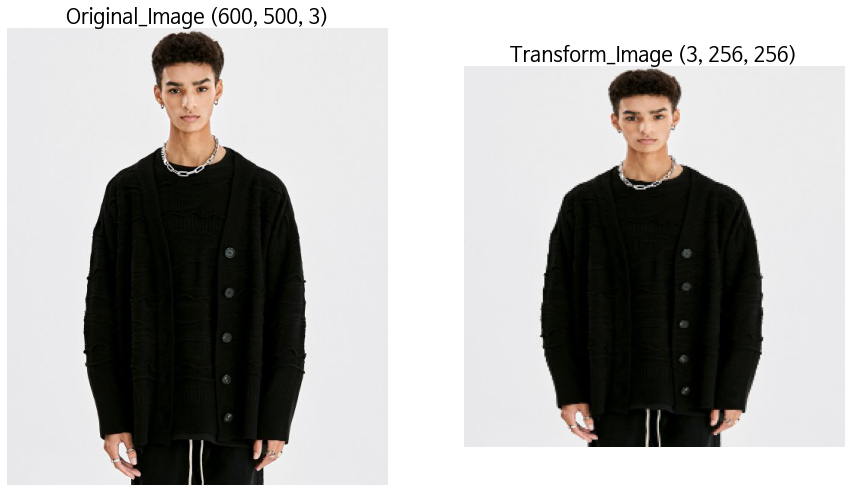

In [ ]:
# 원본 이미지와 transform 된 이미지 비교

fig = plt.figure(figsize=(15, 15))
def custom_imshow(img_transform, img):

    img_transform = img_transform.numpy()
    
    ax1 = fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    ax1.set_title('Original_Image (600, 500, 3)', size = 20)
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(np.transpose(img_transform/255.0, (1, 2, 0))) 
    ax2.set_title('Transform_Image (3, 256, 256)', size = 20)
    ax2.axis("off")
    plt.show()


img = Image.open(df.path[5932]).convert('RGB')
img = np.array(img)
img_transform = train_val_transform(image = img)
img_transform = img_transform['image']

custom_imshow(img_transform, img)

In [ ]:
# EarlyStopping 구현

class EarlyStopping:
    def __init__(self, patience, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.delta = delta
        self.path = '/content/drive/MyDrive/data/save_data/best_model.pth' 

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).\n Saving model ...\n')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss
            

In [ ]:
# train셋 학습

def train(model, optimizer, epoch, scheduler, device):
    model = model.to(device)
    early_stopping = EarlyStopping(patience = 5, verbose = True)  # early_stopping 3으로 설정

    train_losses, val_losses = [], [] # train, val loss 리스트로 저장

    for epoch in range(epoch):
        print(f"\n------ {epoch} epoch -------\n")
        model.train()
        train_loss_list = []
        train_loss = 0.0
        
        for img, label in tqdm(iter(train_loader)):  # Dataloader에 저장된 데이터들이 배치 단위로  나온다.
            img = img.float()/255.0
            img, label = img.to(device), label.to(device)

            optimizer.zero_grad()    # 0으로 초기화
            pred = model(img)
            loss = criterion(pred, label)

            loss.backward()     # gradient 계산
            optimizer.step()    # 파라미터 업데이트

            train_loss_list.append(loss.item())

        if scheduler is not None: 
            scheduler.step()    


        model.eval()
        val_loss = 0.0
        val_loss_list = []
        model_preds = []
        true_labels = []

        correct = 0
        
        # validation으로 평가 
        with torch.no_grad():
            for img, label in tqdm(iter(val_loader)):
                img = img.float()/255.0
                img, label = img.to(device), label.to(device)
                
                val_pred = model(img)
                v_loss = criterion(val_pred, label)

                val_loss_list.append(v_loss.item()) 

                model_preds += val_pred.argmax(1).detach().cpu().numpy().tolist()  # 예측값 추출
                true_labels += label.detach().cpu().numpy().tolist() # 실제값 추출
                
                pred = val_pred.argmax(dim=1, keepdim=True)  
                correct += pred.eq(label.view_as(pred)).sum().item() # 맞춘 개수 
        
        # epoch 당 평균 loss 값 
        train_lossed = np.mean(train_loss_list) 
        val_lossed = np.mean(val_loss_list)

        # epoch 당 모든 평균 loss 리스트로 저장
        train_losses.append(train_lossed)
        val_losses.append(val_lossed)

        # 평가 지표 accuracy, precision, f1_score 선정
        val_accuracy = 100 * correct / len(val_loader.dataset)
        precision = precision_score(true_labels, model_preds, average = 'micro')
        f1 = f1_score(true_labels, model_preds, average = "weighted")

        print(f"\nTrain loss: {train_lossed:.4f}")
        print(f"Val Loss: {val_lossed:.4f}")
        print(f"precsion ------> {precision:.5f}")
        print(f"f1_score ------> {f1:.5f}")
        print(f"{correct} / {len(val_loader.dataset)}, Accuracy: {val_accuracy:.3f}%\n")

        # early_stopping을 통해 오버 피팅 방지
        early_stopping(val_lossed, model)
        if early_stopping.early_stop:
            print('Early Stopping')
            break

        model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'))
    return train_losses, val_losses # 저장된 loss history 리턴
   

In [ ]:
# test셋 평가

def predict(model, test_loader, device):
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'), strict = False)

    model.to(device)
    model.eval()  # test eval 
    model_pred = []
    true_labels = []
    correct = 0
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img = img.float()/255.0
            img, label = img.to(device), label.to(device)
            
            test_pred = model(img)

            model_pred += test_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

            pred = test_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
        
    test_accuracy = 100 * correct / len(test_loader.dataset)
    precision = precision_score(true_labels, model_pred, average = 'micro')
    f1 = f1_score(true_labels, model_pred, average = "weighted")

    print(f"\nprecsion ------> {precision:.5f}")
    print(f"f1_score ------> {f1:.5f}")
    print(f"{correct} / {len(test_loader.dataset)}, Accuracy: {test_accuracy:.3f}%\n")

In [ ]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = torchvision.models.resnet50(pretrained = True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 29)
    
    def forward(self, x):
        return self.model(x)

class MobilenetV2(nn.Module):
    def __init__(self):
        super(MobilenetV2, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        # self.drop = nn.Dropout(p = 0.3)
        self.model.classifier[1] = nn.Linear(1280, 29)

    def forward(self, x):
        # x = self.drop(x)
        return self.model(x)


class Efficientnet(nn.Module):
    def __init__(self):
        super(Efficientnet, self).__init__()
        self.model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
        # self.drop = nn.Dropout(p = 0.3)
        self.model.classifier.fc = nn.Linear(1280, 29)
    
    def forward(self, x):
        # x = self.drop(x)
        return self.model(x)

In [ ]:
# 메모리 캐시 정리

gc.collect()
torch.cuda.empty_cache()

### resnet, mobilenet, efficientnet 3개의 모델로 테스트
> loss: CrossEntropy <br>
> Optimizer: Adam <br>
> learning rate: 0.001

>> best 정확도, 1 epoch 당 시간  
>> resnet: 72%, 9분 <br>
>> mobilenet: 74%, 4분 <br>
>> efficietnet: 75%, 4분 51초  <br>


In [ ]:
criterion = nn.CrossEntropyLoss()

resnet = ResNet50() 
mobilenet = MobilenetV2() 
efficientnet = Efficientnet() 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
resnet_optimizer = optim.Adam(params = resnet.parameters(), lr = 0.001)
resnet_scheduler = optim.lr_scheduler.LambdaLR(resnet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                        last_epoch = -1, verbose = False)

train_loss, val_loss = train(resnet, resnet_optimizer, 20, resnet_scheduler, device)


------ 0 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.39it/s]



Train loss: 1.8306
Val Loss: 1.5031
precsion ------> 0.53162
f1_score ------> 0.51209
2858 / 5389, Accuracy: 53.034%

Validation loss decreased (inf --> 1.503124).
 Saving model ...


------ 1 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.42it/s]



Train loss: 1.2658
Val Loss: 1.5297
precsion ------> 0.53888
f1_score ------> 0.51087
2897 / 5389, Accuracy: 53.758%

EarlyStopping counter: 1 out of 5

------ 2 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.46it/s]



Train loss: 1.2643
Val Loss: 1.5674
precsion ------> 0.52009
f1_score ------> 0.50262
2796 / 5389, Accuracy: 51.883%

EarlyStopping counter: 2 out of 5

------ 3 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.45it/s]



Train loss: 1.2536
Val Loss: 1.2226
precsion ------> 0.61291
f1_score ------> 0.60258
3295 / 5389, Accuracy: 61.143%

Validation loss decreased (1.503124 --> 1.222572).
 Saving model ...


------ 4 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.48it/s]



Train loss: 1.0269
Val Loss: 1.2264
precsion ------> 0.61217
f1_score ------> 0.61087
3291 / 5389, Accuracy: 61.069%

EarlyStopping counter: 1 out of 5

------ 5 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.44it/s]



Train loss: 1.0245
Val Loss: 1.0949
precsion ------> 0.64769
f1_score ------> 0.64545
3482 / 5389, Accuracy: 64.613%

Validation loss decreased (1.222572 --> 1.094937).
 Saving model ...


------ 6 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.42it/s]



Train loss: 0.8573
Val Loss: 1.0212
precsion ------> 0.67746
f1_score ------> 0.67150
3642 / 5389, Accuracy: 67.582%

Validation loss decreased (1.094937 --> 1.021175).
 Saving model ...


------ 7 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.44it/s]



Train loss: 0.7187
Val Loss: 1.0295
precsion ------> 0.68211
f1_score ------> 0.68065
3667 / 5389, Accuracy: 68.046%

EarlyStopping counter: 1 out of 5

------ 8 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.43it/s]



Train loss: 0.6967
Val Loss: 0.9810
precsion ------> 0.69029
f1_score ------> 0.68714
3711 / 5389, Accuracy: 68.862%

Validation loss decreased (1.021175 --> 0.981042).
 Saving model ...


------ 9 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.48it/s]



Train loss: 0.5536
Val Loss: 1.0398
precsion ------> 0.68973
f1_score ------> 0.69291
3708 / 5389, Accuracy: 68.807%

EarlyStopping counter: 1 out of 5

------ 10 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.44it/s]



Train loss: 0.5238
Val Loss: 1.0701
precsion ------> 0.67690
f1_score ------> 0.67405
3639 / 5389, Accuracy: 67.526%

EarlyStopping counter: 2 out of 5

------ 11 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.45it/s]



Train loss: 0.5062
Val Loss: 0.9044
precsion ------> 0.72563
f1_score ------> 0.72457
3901 / 5389, Accuracy: 72.388%

Validation loss decreased (0.981042 --> 0.904434).
 Saving model ...


------ 12 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.48it/s]



Train loss: 0.3796
Val Loss: 1.0278
precsion ------> 0.70945
f1_score ------> 0.70734
3814 / 5389, Accuracy: 70.774%

EarlyStopping counter: 1 out of 5

------ 13 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.43it/s]



Train loss: 0.3485
Val Loss: 1.0891
precsion ------> 0.71019
f1_score ------> 0.70709
3818 / 5389, Accuracy: 70.848%

EarlyStopping counter: 2 out of 5

------ 14 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.43it/s]



Train loss: 0.3355
Val Loss: 1.3159
precsion ------> 0.66871
f1_score ------> 0.66623
3595 / 5389, Accuracy: 66.710%

EarlyStopping counter: 3 out of 5

------ 15 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.40it/s]



Train loss: 0.3214
Val Loss: 1.1125
precsion ------> 0.70219
f1_score ------> 0.70635
3775 / 5389, Accuracy: 70.050%

EarlyStopping counter: 4 out of 5

------ 16 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.42it/s]


Train loss: 0.3102
Val Loss: 1.1327
precsion ------> 0.70201
f1_score ------> 0.70240
3774 / 5389, Accuracy: 70.032%

EarlyStopping counter: 5 out of 5
Early Stopping


Text(0.5, 1.0, 'train vs valid')

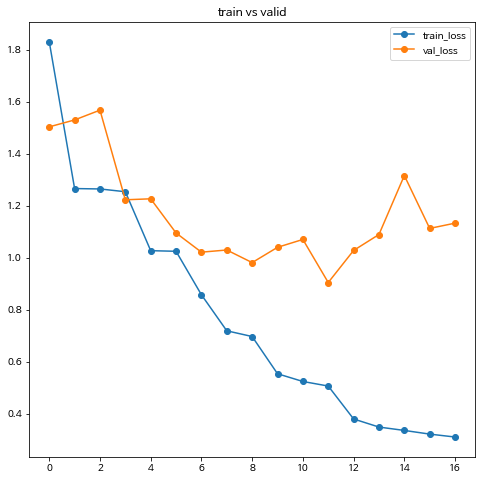

In [ ]:
# train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [ ]:
predict(resnet, test_loader, device)

100%|██████████| 168/168 [22:06<00:00,  7.90s/it]


precsion ------> 0.72377
f1_score ------> 0.72260
3891 / 5389, Accuracy: 72.203%



In [ ]:
mobilenet_optimizer = optim.Adam(params = mobilenet.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.LambdaLR(mobilenet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                         last_epoch = -1, verbose = False)

train_loss, val_loss = train(mobilenet, mobilenet_optimizer, 20, scheduler, device)


------ 0 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.06it/s]



Train loss: 0.5079
Val Loss: 0.8918
precsion ------> 0.73791
f1_score ------> 0.73965
3967 / 5389, Accuracy: 73.613%

Validation loss decreased (inf --> 0.891804).
 Saving model ...


------ 1 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.08it/s]



Train loss: 0.4582
Val Loss: 0.8457
precsion ------> 0.74516
f1_score ------> 0.74682
4006 / 5389, Accuracy: 74.337%

Validation loss decreased (0.891804 --> 0.845745).
 Saving model ...


------ 2 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.14it/s]


Train loss: 0.4074
Val Loss: 0.9067
precsion ------> 0.74293
f1_score ------> 0.74278
3994 / 5389, Accuracy: 74.114%

EarlyStopping counter: 1 out of 5

------ 3 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.20it/s]


Train loss: 0.3592
Val Loss: 0.8878
precsion ------> 0.76544
f1_score ------> 0.76458
4115 / 5389, Accuracy: 76.359%

EarlyStopping counter: 2 out of 5

------ 4 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.10it/s]


Train loss: 0.3156
Val Loss: 0.9338
precsion ------> 0.76283
f1_score ------> 0.76062
4101 / 5389, Accuracy: 76.099%

EarlyStopping counter: 3 out of 5

------ 5 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.15it/s]


Train loss: 0.2741
Val Loss: 0.9752
precsion ------> 0.75521
f1_score ------> 0.75400
4060 / 5389, Accuracy: 75.339%

EarlyStopping counter: 4 out of 5

------ 6 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.25it/s]


Train loss: 0.2370
Val Loss: 1.0065
precsion ------> 0.76246
f1_score ------> 0.76031
4099 / 5389, Accuracy: 76.062%

EarlyStopping counter: 5 out of 5
Early Stopping


Text(0.5, 1.0, 'train vs valid')

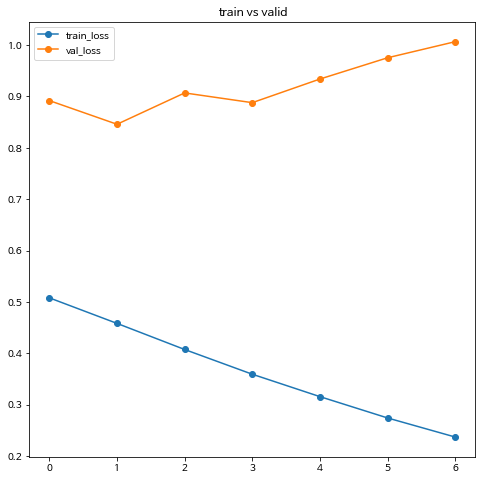

In [ ]:
# train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [ ]:
predict(mobilenet, test_loader, device)

100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


precsion ------> 0.74609
f1_score ------> 0.74109
4011 / 5389, Accuracy: 74.429%



In [ ]:
efficientnet_optimizer = optim.Adam(params = efficientnet.parameters(), lr = 0.001)
efficientnet_scheduler = optim.lr_scheduler.LambdaLR(efficientnet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                                     last_epoch = -1, verbose = False)
    
train_loss, val_loss = train(efficientnet, efficientnet_optimizer, 20, efficientnet_scheduler, device)


------ 0 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.84it/s]



Train loss: 0.0353
Val Loss: 1.5380
precsion ------> 0.75781
f1_score ------> 0.75841
4074 / 5389, Accuracy: 75.598%

Validation loss decreased (inf --> 1.537981).
 Saving model ...


------ 1 epoch -------



100%|██████████| 168/168 [00:18<00:00,  9.27it/s]



Train loss: 0.0318
Val Loss: 1.5822
precsion ------> 0.76135
f1_score ------> 0.76130
4093 / 5389, Accuracy: 75.951%

EarlyStopping counter: 1 out of 5

------ 2 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.02it/s]



Train loss: 0.0280
Val Loss: 1.6214
precsion ------> 0.75428
f1_score ------> 0.75254
4055 / 5389, Accuracy: 75.246%

EarlyStopping counter: 2 out of 5

------ 3 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.47it/s]



Train loss: 0.0274
Val Loss: 1.6265
precsion ------> 0.75725
f1_score ------> 0.75776
4071 / 5389, Accuracy: 75.543%

EarlyStopping counter: 3 out of 5

------ 4 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.43it/s]



Train loss: 0.0283
Val Loss: 1.5765
precsion ------> 0.76395
f1_score ------> 0.76346
4107 / 5389, Accuracy: 76.211%

EarlyStopping counter: 4 out of 5

------ 5 epoch -------



100%|██████████| 168/168 [00:16<00:00,  9.90it/s]


Train loss: 0.0280
Val Loss: 1.5653
precsion ------> 0.75837
f1_score ------> 0.75927
4077 / 5389, Accuracy: 75.654%

EarlyStopping counter: 5 out of 5
Early Stopping


Text(0.5, 1.0, 'train vs valid')

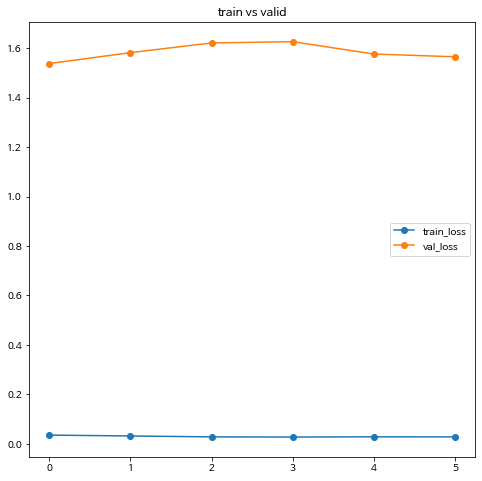

In [ ]:
 # train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [ ]:
predict(efficientnet, test_loader, device)

100%|██████████| 168/168 [00:45<00:00,  3.73it/s]


precsion ------> 0.75260
f1_score ------> 0.75355
4046 / 5389, Accuracy: 75.079%



In [ ]:
efficientnet.model.classifier.fc

Linear(in_features=1280, out_features=29, bias=True)

In [ ]:
# 마지막 convolution layer
# 분류 부분 파라미터 추출

final_conv = efficientnet.model.features.bn
print(final_conv)
fc_params = list(efficientnet.model.classifier.fc.parameters())

BatchNorm2d(1280, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)


## 성능이 가장 좋았던 efficientnet을 통해 Grad-CAM 시각화 
> 현재 히트맵을 통해 시각화를 하는 것은 가능합니다

> 목표하고자 하는 것
>> 정답과 오답을 나누어 5개 씩 히트맵 확인

In [ ]:
fc_params

[Parameter containing:
 tensor([[-0.0067,  0.0705,  0.7288,  ..., -0.3875, -0.1106, -0.1409],
         [-0.1138,  0.2375, -1.1238,  ...,  0.3981,  0.0411,  0.0621],
         [-0.0168, -0.0125, -0.6889,  ..., -0.1153, -0.0830, -0.0143],
         ...,
         [ 0.1928, -0.0411, -0.3509,  ..., -0.2936, -0.0389,  0.3279],
         [ 0.1843,  0.0636,  0.2376,  ..., -0.2129,  0.1203, -1.0110],
         [-0.0876,  0.0369, -0.1235,  ...,  0.4495, -0.0188,  0.0420]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 0.1188, -1.0098,  0.5140,  1.2170, -0.0204,  0.9911, -0.0068, -0.1372,
         -0.5208, -1.3701, -0.5929, -0.4206, -1.2130, -0.9933,  0.0827,  0.8599,
         -0.8163, -0.6156,  0.0374, -0.3307,  0.5813,  0.1596,  0.2425,  0.2812,
          0.1625, -0.1895,  0.2846, -0.7893,  0.1400], device='cuda:0',
        requires_grad=True)]

In [ ]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()



    # return cam_img


def plotGradCAM(model, final_conv, fc_params, train_loader, 
                row=1, col=10, img_size=224, device='cpu', original = False):
    for param in model.parameters():
        param.requires_grad = False
    
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/resnet_best_model.pth'), strict = False)
    model.to(device)
    model.eval()
    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)

    # save weight from fc
    weight = np.squeeze(fc_params[0].cpu().data.numpy()) # 29, 2048 

    # heatmap images

    fig = plt.figure(figsize=(30, 30))
    # fig = plt.figure(figsize=(10, 10))
    for i, (img, target) in enumerate(tqdm(test_loader)):
        output = model(img.to(device))
        pred_idx = output.to('cpu').numpy().argmax(1)
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))

        # getCAM(activated_features.features, weight, pred_idx, cur_images)

        _, nc, h, w = activated_features.features.shape # chanel, height, width 언패킹

        # cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
        # print(cam)

        # print(activated_features.features[0, :, :, ].reshape((nc, h*w)).shape)

        # print(weight)

        # cam = cam[0, :].reshape(h, w)
        # cam = cam - np.min(cam)
        # cam_img = cam / np.max(cam)
        # print(cam_img.shape)
    for i in range(5):
        cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
        cam = cam[i, :].reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        # print(cam_img.shape)
        cam_img = cam_img.astype(np.uint16)
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        # ax.set_title('Label:%s, Predict:%s'% (df['name'].unique()[target[i]], df['name'].unique()[pred_idx[i]]), fontsize=14)
        ax.set_title('Label:%d, Predict:%d'% (target[i], pred_idx[i]), fontsize=14)
        # heatmap = getCAM(activated_features.features, weight, pred_idx)
        # ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])

        # plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB))
        # plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        # ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)

        # if i == row*col-1:
        #     break
    plt.show()

In [ ]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

def getCAM(activated_features, weight, nc, h, w, pred_idx, i):
    cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
    cam = cam[i, :].reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img
    

def plotGradCAM(model, final_conv, fc_params, train_loader, 
                row=1, col=10, img_size=256, device='cpu', original=False):

    for param in model.parameters():
        param.requires_grad = False
    
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/resnet_best_model.pth'), strict = False)
    model.to(device)

    model_pred = []
    true_labels = []
    cam_correct = []
    cam_incorrect = []

    correct = 0
    model.eval()

    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)

    # save weight from fc
    weight = np.squeeze(fc_params[0].cpu().data.numpy())

    # heatmap images
    fig = plt.figure(figsize = (30, 30))

    for img, label in tqdm(iter(test_loader)):
        img = img.float()/255.0
        output = model(img.to(device))
        pred_idx = output.to('cpu').numpy().argmax(1)
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))

        model_pred += output.argmax(1).detach().cpu().numpy().tolist()
        true_labels += label.detach().cpu().numpy().tolist()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()

        _, nc, h, w = activated_features.features.shape # chanel, height, width 언패킹
   


    for i in range(10):
        heatmap = getCAM(activated_features, weight, nc, h, w, pred_idx, i)
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        ax.set_title('Label:%d, Predict:%d'% (label[i], pred_idx[i]), fontsize=14)
        plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.resize(heatmap, (256, 256), interpolation=cv2.INTER_LINEAR), alpha=0.3, cmap='jet')
        
    # for idx in range(len(model_pred)):
        
    #     if model_pred[idx] == true_labels[idx]:
    #         cam_correct.append(model_pred[idx])
    #     else:
    #         cam_incorrect.append(model_pred[idx])
        
    #     heatmap = getCAM(activated_features, weight, nc, h, w, pred_idx, idx)
    #     ax = fig.add_subplot(5, 1, idx+1, xticks=[], yticks=[])
    #     ax.set_title('Label:%d, Predict:%d'% (label[idx], pred_idx[idx]), fontsize=14)

        # ax.set_title('Label:%d, Predict:%d'% (label[idx], pred_idx[idx]), fontsize=14)
    
        # plt.imshow(cv2.cvtColor(cur_images[idx], cv2.COLOR_BGR2RGB))
        # plt.imshow(cv2.resize(heatmap, (256, 256), interpolation=cv2.INTER_LINEAR), alpha=0.3, cmap='jet')
    

    # ax.set_title('Label:%s, Predict:%s'% (df['name'].unique()[target[i]], df['name'].unique()[pred_idx[i]]), fontsize=14)
    
    print('correct', cam_correct)
    print('incorrect', cam_incorrect)

    # if i == row*col-1:
    #     break

    test_accuracy = 100 * correct / len(test_loader.dataset)
    precision = precision_score(true_labels, model_pred, average = 'micro')
    f1 = f1_score(true_labels, model_pred, average = "weighted")


    print(cur_images.shape)
    print(f"\nprecsion ------> {precision:.5f}")
    print(f"f1_score ------> {f1:.5f}")
    print(f"{correct} / {len(test_loader.dataset)}, Accuracy: {test_accuracy:.3f}%\n")
    plt.show()
    

100%|██████████| 168/168 [03:42<00:00,  1.32s/it]


correct []
incorrect []
(32, 256, 256, 3)

precsion ------> 0.75260
f1_score ------> 0.75355
4046 / 5389, Accuracy: 75.079%



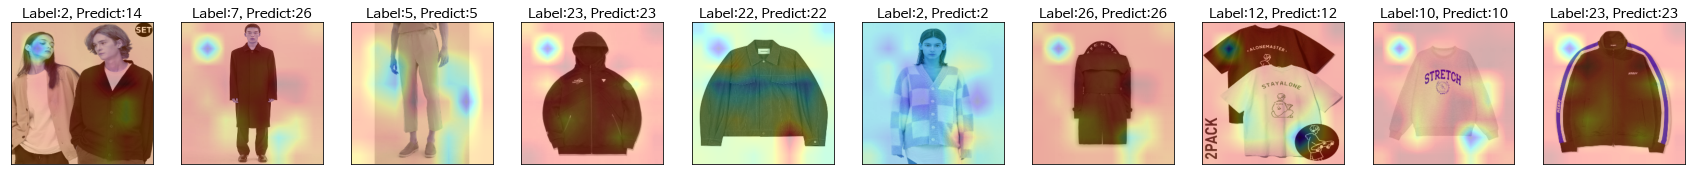

In [ ]:
plotGradCAM(efficientnet, final_conv, fc_params, test_loader)

In [ ]:
# class SaveFeatures():
#     features = None
#     def __init__(self, m):
#         self.hook = m.register_forward_hook(self.hook_fn)

#     def hook_fn(self, module, input, output):
#         self.features = ((output.cpu()).data).numpy()

#     def remove(self):
#         self.hook.remove()

# def getCAM(feature_conv, weight_fc, class_idx):
#     _, nc, h, w = feature_conv.shape

#     cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
    
#     cam = cam[0, :].reshape(h, w)

#     print(cam)
#     cam = cam - np.min(cam)
#     cam_img = cam / np.max(cam)
#     return cam_img

# def plotGradCAM(model, final_conv, fc_params, test_loader, row = 1, col = 8,
#                 img_size = 224, device = device, original = False):
#     model.to(device)
#     model.eval()

#     model_pred = []
#     true_labels = []

#     activated_features = SaveFeatures(final_conv)
#     weight = np.squeeze(fc_params[0].cpu().data.numpy())


#     for i, (img, label) in enumerate(test_loader):
#         img, label = img.to(device), label.to(device)

#         test_pred = model(img)
#         pred_idx = test_pred.detach().cpu().numpy().argmax(1)
#         cur_images = img.detach().cpu().numpy()
#         cur_images = img.detach().cpu().numpy().transpose((0, 2, 3, 1))
#         heatmap = getCAM(activated_features.features, weight, pred_idx)
#         print(heatmap)
            